In [1]:
import copy
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib.animation import FuncAnimation
from tqdm.auto import trange, tqdm

sys.path.append("..")
from burgers.plot import plot_2d
from neural_rk.grid_graph import edge2dxdy, node2grid, to_periodic_field
from neural_rk.modules import count_trainable_param
from neural_rk.path import DATA_DIR, FIG_DIR

rng = np.random.default_rng(42)
device = torch.device("cuda:0")

# Data
### Notations
- $N_x$: Number of grid points at x-axis
- $N_y$: Number of grid points at y-axis
- $N$: number of all grid points. e.g., for 2D square lattice, $N = N_x * N_y$
- $E$: number of edges. e.g., for 2D square lattice with periodic B.C., $E = 2 * N$
- $S$: number of time steps

### Grid to Graph mapping
<pre>
3 -- 4 -- 5
|    |    |
0 -- 1 -- 2
</pre>
node: 0, 1, 2, 3, 4, 5

edge: (0, 1), (0, 3), (1, 2), (1, 4), (2, 5), (2, 0), (3, 4), (3, 0), (4, 5), (4, 1), (5, 3), (5, 2)


### Values of dataframe
- Optimized for GNN. Need to do pre-processing for others
- All values except network_type are torch.Tensor type with float32 precision

1. network_type: Nx_Ny. e.g., 100_100 if N_x=100 and N_y=100
2. edge_index: [2, $E$], which node is connected to which node
3. node_attr: [$N$, 2], all ones. If 1D burgers equation, node_attr[:, 1] = 0
4. edge_attr: [$E$, 2], distance of each edges.\
   edge_attr[:, 0]: nonzero for x-axis edge, edge_attr[:, 1]: nonzero for y-axis edge
5. glob_attr: [1, 2], [[nu, nu]] where nu is diffusion term of burgers equation.\
   If 1D burgers equation, [[nu, 0]]
6. dts: [$S$, 1], dt of each time step
7. trajectories: [$S+1$, $N$, 2], u, v value of each time step, each node. Length is $S+1$ since it contains initial condition

In [2]:
test_id = "IC_train"
sample_idx = 0
exp_id = "PINN"

df = pd.read_pickle(DATA_DIR / f"burgers_{test_id}.pkl")
data = df.iloc[sample_idx]
data

network_type                                              100_100
edge_index      [[tensor(0), tensor(0), tensor(1), tensor(1), ...
node_attr       [[tensor(1.), tensor(1.)], [tensor(1.), tensor...
edge_attr       [[tensor(0.0100), tensor(0.)], [tensor(0.), te...
glob_attr                      [[tensor(0.0100), tensor(0.0100)]]
dts             [[tensor(0.0010)], [tensor(0.0010)], [tensor(0...
trajectories    [[[tensor(-0.3704), tensor(0.7340)], [tensor(-...
Name: 0, dtype: object

### Change to grid

In [3]:
# Extract Nx, Ny
Nx, Ny = tuple(map(int, data.network_type.split("_")))

# Extract dx, dy: spacing of x-axis and y-axis
# dx: [Nx, ], dy: [Ny, ]
dx, dy = edge2dxdy(data.edge_attr, Nx, Ny)
x = np.insert(np.cumsum(dx), 0, 0.0)
y = np.insert(np.cumsum(dy), 0, 0.0)

# Convert dx, dy to position of all grid points
# Because of periodic B.C., position[Ny, Nx] should be equal to position[0, 0], and other boundaries too
# position: [Ny+1, Nx+1, 2], where position[..., 0], position[..., 1] are x, y value of each point
position = np.stack(np.meshgrid(x, y), axis=-1)

# Convert trajectory to grid shape trajectory
# node2grid: [N, 2] -> [Ny, Nx, 2], to_periodic_field: [Ny, Nx, 2] -> [Ny+1, Nx+1, 2]
# trajectory: [S+1, Ny+1, Nx+1, 2]
trajectory = np.stack(
    [to_periodic_field(node2grid(traj, Nx, Ny)) for traj in data.trajectories], axis=0
)

# Extract time of shape [S+1, ]
time = np.insert(np.cumsum(data.dts.numpy()), 0, 0.0)

# Extract nu of shape [2,]
nu = data.glob_attr.numpy().squeeze()

# PINN
#### NOTE : Full-batch training

In [4]:
ic_sparsity = 1.0  # Sparsity of choosing grid points for initial condition
bc_sparsity = 0.1  # Sparsity of choosing grid points for boundary condition
pde_sparsity = 0.002  # Sparsity of choosing grid points for PDE condition
data_sparsity = 0.002  # Sparsity of choosing grid points for data condition
val_sparsity = 0.1  # Sparsity of choosing grid points for validation

# Mesh of x, y, t, [Ny+1, Nx+1, S+1, 3]
xyt = torch.tensor(np.stack(np.meshgrid(x, y, time), axis=-1), device=device)
trajectory = torch.tensor(trajectory, device=device)

# ------------------------ Initial condition ------------------------
# Extract x, y, t, field for initial condition
# [Ny + 1, Nx+1, 1] -> [(Ny+1) * (Nx+1), 1]
ic_x = xyt[:, :, 0, 0].reshape(-1, 1)
ic_y = xyt[:, :, 0, 1].reshape(-1, 1)
ic_t = torch.zeros_like(ic_x)
ic_field = trajectory[0].reshape(-1, 2)

# Randomly prune data according to sparsity
ic_idx = rng.choice(len(ic_x), int(ic_sparsity * len(ic_x)), replace=False)
ic_x = ic_x[ic_idx]
ic_y = ic_y[ic_idx]
ic_t = ic_t[ic_idx]
ic_field = ic_field[ic_idx]

# ------------------------ Boundary condition ------------------------
# Extract x, y, t, field for boundary condition
# bc1: left, bottom, bc2: right, top
bc1_x = torch.cat((xyt[0, :, :, 0], xyt[1:, 0, :, 0]), dim=0).reshape(-1, 1)
bc1_y = torch.cat((xyt[0, :, :, 1], xyt[1:, 0, :, 1]), dim=0).reshape(-1, 1)
bc1_t = torch.cat((xyt[0, :, :, 2], xyt[1:, 0, :, 2]), dim=0).reshape(-1, 1)
bc2_x = torch.cat((xyt[-1, :-1, :, 0], xyt[:, -1, :, 0]), dim=0).reshape(-1, 1)
bc2_y = torch.cat((xyt[-1, :-1, :, 1], xyt[:, -1, :, 1]), dim=0).reshape(-1, 1)
bc2_t = torch.cat((xyt[-1, :-1, :, 2], xyt[:, -1, :, 2]), dim=0).reshape(-1, 1)

# Randomly prune data according to sparsity
# requires_grad = True for derivative of boundary
bc_idx = rng.choice(len(bc1_x), int(bc_sparsity * len(bc1_x)), replace=False)
bc1_x = bc1_x[bc_idx].requires_grad_(True)
bc1_y = bc1_y[bc_idx].requires_grad_(True)
bc1_t = bc1_t[bc_idx].requires_grad_(True)
bc2_x = bc2_x[bc_idx].requires_grad_(True)
bc2_y = bc2_y[bc_idx].requires_grad_(True)
bc2_t = bc2_t[bc_idx].requires_grad_(True)

# ------------------------ PDE condition ------------------------
# Extract x, y, t, field for PDE condition
pde_x = xyt[..., 0].reshape(-1, 1)
pde_y = xyt[..., 1].reshape(-1, 1)
pde_t = xyt[..., 2].reshape(-1, 1)

# Randomly prune data according to sparsity
# requires_grad = True for derivative
pde_idx = rng.choice(len(pde_x), int(pde_sparsity * len(pde_x)), replace=False)
pde_x = pde_x[pde_idx].requires_grad_(True)
pde_y = pde_y[pde_idx].requires_grad_(True)
pde_t = pde_t[pde_idx].requires_grad_(True)

# ------------------------ Data condition ------------------------
data_x = xyt[..., 0].reshape(-1, 1)
data_y = xyt[..., 1].reshape(-1, 1)
data_t = xyt[..., 2].reshape(-1, 1)
data_field = trajectory.reshape(-1, 2)

# Randomly prune data according to sparsity
data_idx = rng.choice(len(data_x), int(data_sparsity * len(data_x)), replace=False)
data_x = data_x[data_idx]
data_y = data_y[data_idx]
data_t = data_t[data_idx]
data_field = data_field[data_idx]

# ------------------------ Validation ------------------------
# Take all simulation points for validation
val_x = xyt[..., 0].reshape(-1, 1)
val_y = xyt[..., 1].reshape(-1, 1)
val_t = xyt[..., 2].reshape(-1, 1)
val_field = trajectory.reshape(-1, 2)

# Randomly prune data according to sparsity
val_idx = rng.choice(len(val_x), int(val_sparsity * len(val_x)), replace=False)
val_x = val_x[val_idx]
val_y = val_y[val_idx]
val_t = val_t[val_idx]
val_field = val_field[val_idx]


In [5]:
def get_batch_norm_layer(in_channels: int, bn_momentum: float = 1.0) -> nn.Module:
    """Return batch normalization with given momentum
    if given momentum is 1.0, return identity layer"""
    if bn_momentum == 1.0:
        return nn.Identity()
    else:
        return nn.BatchNorm1d(in_channels, momentum=bn_momentum)


def get_dropout_layer(dropout: float = 0.0) -> nn.Module:
    """Return batch normalization with given momentum
    if given momentum is 1.0, return identity layer"""
    if dropout == 0.0:
        return nn.Identity()
    else:
        return nn.Dropout(dropout)


class Model(nn.Module):
    def __init__(
        self, hidden_dim: int = 32, depth: int = 6, bn_momentum: float = 1.0, dropout: float = 0.0
    ) -> None:
        """
        Create 2-layer MLP module
        If last, do not use last activations
        """
        super().__init__()
        use_bias = bn_momentum == 1.0

        def get_slp_layer(
            in_dim: int, out_dim: int, last: bool = False
        ) -> list[nn.Module]:
            if last:
                return [nn.Linear(in_dim, out_dim, bias=use_bias)]
            else:
                return [
                    nn.Linear(in_dim, hidden_dim, bias=use_bias),
                    get_batch_norm_layer(hidden_dim, bn_momentum),
                    nn.GELU(),
                    get_dropout_layer(dropout),
                ]

        # 3 -> hidden -> ... -> hidden -> 2
        modules = get_slp_layer(3, hidden_dim)
        for _ in range(depth - 2):
            modules.extend(get_slp_layer(hidden_dim, hidden_dim))
        modules.extend(get_slp_layer(hidden_dim, 2, last=True))

        self.mlp = nn.Sequential(*modules)

    def forward(
        self, x: torch.Tensor, y: torch.Tensor, t: torch.Tensor
    ) -> torch.Tensor:
        return self.mlp(torch.cat([x, y, t], dim=-1))


In [6]:
def bc_derivative_loss(
    x1: torch.Tensor,
    y1: torch.Tensor,
    t1: torch.Tensor,
    field1: torch.Tensor,
    x2: torch.Tensor,
    y2: torch.Tensor,
    t2: torch.Tensor,
    field2: torch.Tensor,
) -> torch.Tensor:
    """
    MSE loss of derivatives at boundary:
    u_x(left) = u_x(right), u_x(bottom) = u_x(top)
    u_y(left) = u_y(right), u_y(bottom) = u_y(top)
    u_t(left) = u_t(right), u_t(bottom) = u_t(top)
    v_x(left) = v_x(right), v_x(bottom) = v_x(top)
    v_y(left) = v_y(right), v_y(bottom) = v_y(top)
    v_t(left) = v_t(right), v_t(bottom) = v_t(top)

    Args:
    x, y, t, field: positions, time, field at boundary
    x, y, t: [num_data, 1]
    field: [num_data, 2]
    """
    u1, v1 = field1.T
    u1, v1 = u1.unsqueeze(-1), v1.unsqueeze(-1)
    u2, v2 = field2.T
    u2, v2 = u2.unsqueeze(-1), v2.unsqueeze(-1)

    u1_x = torch.autograd.grad(u1, x1, torch.ones_like(u1), create_graph=True)[0]
    u1_y = torch.autograd.grad(u1, y1, torch.ones_like(u1), create_graph=True)[0]
    u1_t = torch.autograd.grad(u1, t1, torch.ones_like(u1), create_graph=True)[0]
    v1_x = torch.autograd.grad(v1, x1, torch.ones_like(v1), create_graph=True)[0]
    v1_y = torch.autograd.grad(v1, y1, torch.ones_like(v1), create_graph=True)[0]
    v1_t = torch.autograd.grad(v1, t1, torch.ones_like(v1), create_graph=True)[0]

    u2_x = torch.autograd.grad(u2, x2, torch.ones_like(u2), create_graph=True)[0]
    u2_y = torch.autograd.grad(u2, y2, torch.ones_like(u2), create_graph=True)[0]
    u2_t = torch.autograd.grad(u2, t2, torch.ones_like(u2), create_graph=True)[0]
    v2_x = torch.autograd.grad(v2, x2, torch.ones_like(v2), create_graph=True)[0]
    v2_y = torch.autograd.grad(v2, y2, torch.ones_like(v2), create_graph=True)[0]
    v2_t = torch.autograd.grad(v2, t2, torch.ones_like(v2), create_graph=True)[0]

    bc_derivative1 = torch.cat([u1_x, u1_y, u1_t, v1_x, v1_y, v1_t], dim=-1)
    bc_derivative2 = torch.cat([u2_x, u2_y, u2_t, v2_x, v2_y, v2_t], dim=-1)

    return F.mse_loss(bc_derivative1, bc_derivative2)


def pde_loss(
    x: torch.Tensor,
    y: torch.Tensor,
    t: torch.Tensor,
    field: torch.Tensor,
    nu: torch.Tensor,
) -> torch.Tensor:
    """
    MSE loss of burgers equation
    u_t + u * u_x + v * u_y - nu * (u_xx + u_yy) = 0
    v_t + u * v_x + v * v_y - nu * (v_xx + v_yy) = 0

    Args
    x, y, t, field: positions, time, field at boundary
    x, y, t: [num_data, 1]
    field: [num_data, 2]
    nu: [2, ]
    """
    u, v = field.T
    u, v = u.unsqueeze(-1), v.unsqueeze(-1)

    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, torch.ones_like(v), create_graph=True)[0]
    v_t = torch.autograd.grad(v, t, torch.ones_like(v), create_graph=True)[0]

    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x, torch.ones_like(v_x), create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y, torch.ones_like(v_y), create_graph=True)[0]

    loss_u = u_t + u * u_x + v * u_y - nu[0] * (u_xx + u_yy)
    loss_v = v_t + u * v_x + v * v_y - nu[1] * (v_xx + v_yy)

    return torch.cat((loss_u, loss_v), dim=-1).square().mean()

In [7]:
model = Model(hidden_dim=64).to(device)

optimizer = optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)

print(f"Trainable parameters: {count_trainable_param(model)}")
print(f"Number of initial condtion points: {len(ic_x)}")
print(f"Number of boundary condtion points: {len(bc1_x)}")
print(f"Number of pde points: {len(pde_x)}")
print(f"Number of data points: {len(data_x)}")

Trainable parameters: 17026
Number of initial condtion points: 10201
Number of boundary condtion points: 40220
Number of pde points: 40824
Number of data points: 40824


In [8]:
epochs = 3000

mse_ic: list[float] = []
mse_bc_value: list[float] = []
mse_bc_derivative: list[float] = []
mse_pde: list[float] = []
mse_data: list[float] = []
mse_train: list[float] = []
mse_test: list[float] = []

best_val_loss = 99999999.0
best_model_state_dict = copy.deepcopy(model.state_dict())

for epoch in trange(epochs):
    model.train()

    # Initial condition
    pred_ic = model(ic_x, ic_y, ic_t)
    ic_mse = F.mse_loss(pred_ic, ic_field)

    # Boundary condition
    pred_bc1 = model(bc1_x, bc1_y, bc1_t)
    pred_bc2 = model(bc2_x, bc2_y, bc2_t)

    bc_mse_value = F.mse_loss(pred_bc1, pred_bc2)
    bc_mse_derivative = bc_derivative_loss(
        bc1_x, bc1_y, bc1_t, pred_bc1, bc2_x, bc2_y, bc2_t, pred_bc2
    )

    # PDE condition
    pde_pred = model(pde_x, pde_y, pde_t)
    pde_mse = pde_loss(pde_x, pde_y, pde_t, pde_pred, nu)

    # Data condition
    data_pred = model(data_x, data_y, data_t)
    data_mse = F.mse_loss(data_pred, data_field)

    # Combining the loss functions
    loss = (
        1.0 * ic_mse
        + 1.0 * bc_mse_value
        + 1.0 * bc_mse_derivative
        + 2.0 * pde_mse
        + 0.0 * data_mse
    )

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # Validation
    with torch.no_grad():
        model.eval()
        val_pred = model(val_x, val_y, val_t)
        val_loss = F.mse_loss(val_pred, val_field).item()
    mse_ic.append(ic_mse.item())
    mse_bc_value.append(bc_mse_value.item())
    mse_bc_derivative.append(bc_mse_derivative.item())
    mse_pde.append(pde_mse.item())
    mse_data.append(data_mse.item())
    mse_train.append(loss.item())
    mse_test.append(val_loss)

    # Save best model
    if val_loss >= best_val_loss:
        continue
    best_val_loss = val_loss
    best_model_state_dict = copy.deepcopy(model.state_dict())
    tqdm.write(f"{epoch}: train loss={loss.item():.4e}, val loss={val_loss:.4e}")

# Load best model state
model.load_state_dict(best_model_state_dict)

  0%|          | 0/3000 [00:00<?, ?it/s]

0: train loss=2.5356e-01, val loss=1.1310e-01
1: train loss=2.5225e-01, val loss=1.0591e-01
2: train loss=2.5160e-01, val loss=1.0002e-01
3: train loss=2.5157e-01, val loss=9.6686e-02
4: train loss=2.5186e-01, val loss=9.5962e-02
117: train loss=1.8710e-01, val loss=9.5152e-02
120: train loss=1.8255e-01, val loss=9.4915e-02
499: train loss=1.0966e-01, val loss=9.4515e-02
555: train loss=1.0236e-01, val loss=9.3791e-02
557: train loss=1.0417e-01, val loss=9.2865e-02
626: train loss=9.8292e-02, val loss=9.2783e-02
661: train loss=9.8574e-02, val loss=9.2135e-02
664: train loss=9.2081e-02, val loss=9.1155e-02
746: train loss=7.9551e-02, val loss=9.1007e-02
748: train loss=7.9522e-02, val loss=9.0751e-02
763: train loss=7.6779e-02, val loss=9.0579e-02
765: train loss=7.6807e-02, val loss=9.0281e-02
767: train loss=7.7489e-02, val loss=8.9870e-02
769: train loss=8.0942e-02, val loss=8.9090e-02
771: train loss=8.9687e-02, val loss=8.8199e-02
819: train loss=7.3645e-02, val loss=8.7872e-02
82

<All keys matched successfully>

In [18]:
# checkpoint = {
#     "best_model_state_dict": model.state_dict(),
#     "ic": mse_ic,
#     "bc_value": mse_bc_value,
#     "bc_derivative": mse_bc_derivative,
#     "pde": mse_pde,
#     "train": mse_train,
#     "test": mse_test,
# }
# torch.save(checkpoint, "result/example.pth")


# checkpoint = torch.load("result/example.pth")
# model.load_state_dict(checkpoint["best_model_state_dict"])
# mse_ic = checkpoint["ic"]
# mse_bc_value = checkpoint["bc_value"]
# mse_bc_derivative = checkpoint["bc_derivative"]
# mse_pde = checkpoint["pde"]
# mse_train = checkpoint["train"]
# mse_test = checkpoint["test"]

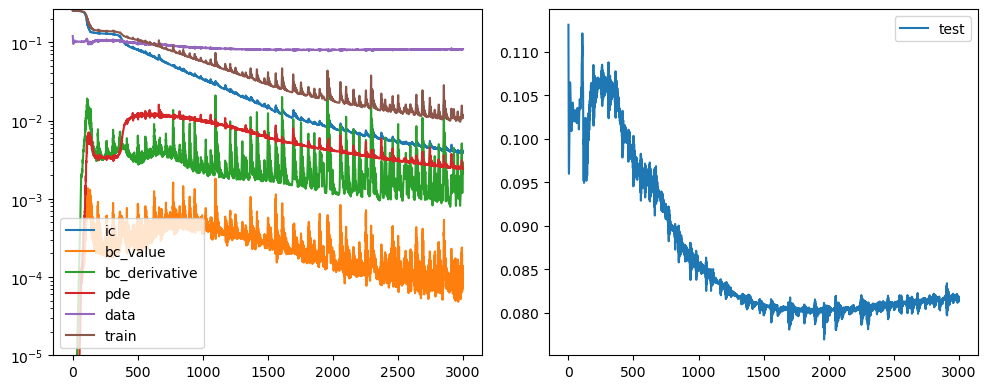

In [14]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), ncols=2)

ax1.plot(mse_ic, label="ic")
ax1.plot(mse_bc_value, label="bc_value")
ax1.plot(mse_bc_derivative, label="bc_derivative")
ax1.plot(mse_pde, label="pde")
ax1.plot(mse_data, label="data")
ax1.plot(mse_train, label="train")

ax1.legend()
ax1.set_ylim(bottom=1e-5)
ax1.set_yscale("log")

ax2.plot(mse_test, label="test")
ax2.legend()

fig.tight_layout()
fig.show()

# Test

In [15]:
num_batch = 4
num_steps = xyt.shape[2]    # [Ny+1, Nx+1, S+1, 3] -> S+1

pred_trajectories = []
with torch.no_grad():
    model.eval()

    for batch in range(num_batch):
        start = int(num_steps / num_batch * batch)
        end = int(num_steps / num_batch * (batch + 1)) if batch < num_batch - 1 else num_steps

        xyt_batch = xyt[:, :, start:end].reshape(-1, 3, 1)
        prediction = model(xyt_batch[:, 0], xyt_batch[:, 1], xyt_batch[:, 2])

        # [Ny+1, Nx+1, batch_step, 2]
        pred_trajectories.append(prediction.reshape(Ny + 1, Nx + 1, -1, 2))

# [S+1, Ny+1, Nx+1, 2]
pred_trajectory = torch.cat(pred_trajectories, dim=2).permute(2, 0, 1, 3).cpu().numpy()
true_trajectory = trajectory.cpu().numpy()

In [16]:
error = true_trajectory - pred_trajectory
print(f"MAE={np.abs(error).mean():.4e}, in range {error.min(), error.max()}")

MAE=8.4502e-02, in range (-0.47358733, 0.5026393)


In [12]:
error = true_trajectory - pred_trajectory
print(f"MAE={np.abs(error).mean():.4e}, in range {error.min(), error.max()}")

MAE=9.2987e-02, in range (-0.3860365, 0.48925602)


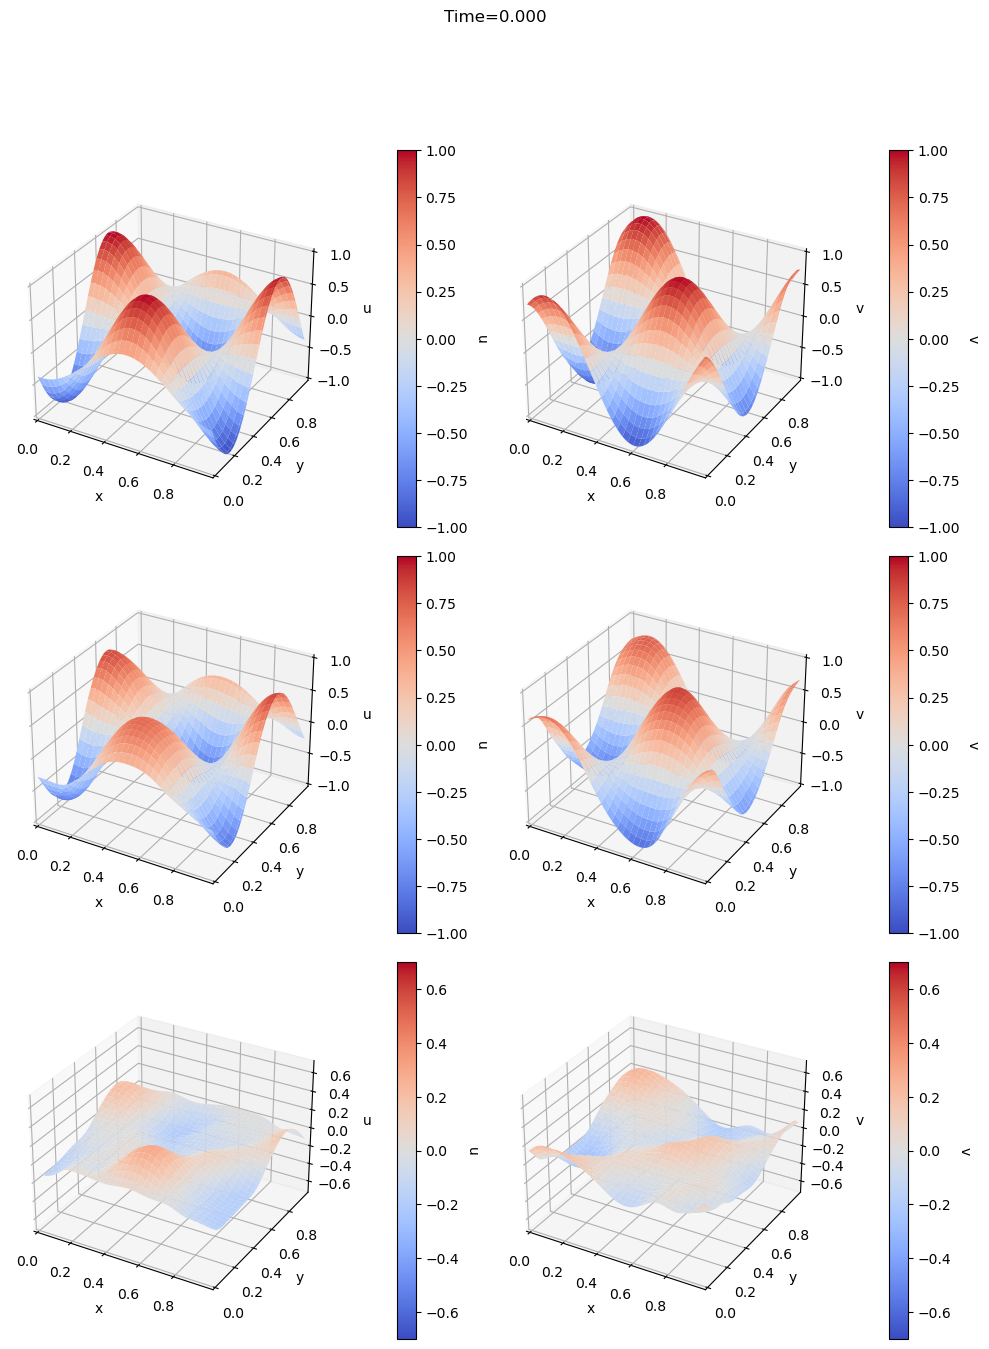

In [17]:
skip_frame = 10

fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(321, projection="3d")
ax2 = fig.add_subplot(322, projection="3d")
ax3 = fig.add_subplot(323, projection="3d")
ax4 = fig.add_subplot(324, projection="3d")
ax5 = fig.add_subplot(325, projection="3d")
ax6 = fig.add_subplot(326, projection="3d")

ax1.set_title("True")
sf1, sf2 = plot_2d(ax1, ax2, position, true_trajectory[0], to_periodic=False)
cbar1 = ax1.figure.colorbar(sf1, ax=ax1, shrink=0.6, pad=0.15)
cbar1.ax.set_ylabel("u", rotation=-90, va="bottom")
cbar2 = ax2.figure.colorbar(sf2, ax=ax2, shrink=0.6, pad=0.15)
cbar2.ax.set_ylabel("v", rotation=-90, va="bottom")


ax3.set_title("Pred")
sf3, sf4 = plot_2d(ax3, ax4, position, pred_trajectory[0], to_periodic=False)
cbar3 = ax3.figure.colorbar(sf3, ax=ax3, shrink=0.6, pad=0.15)
cbar3.ax.set_ylabel("u", rotation=-90, va="bottom")
cbar4 = ax4.figure.colorbar(sf4, ax=ax4, shrink=0.6, pad=0.15)
cbar4.ax.set_ylabel("v", rotation=-90, va="bottom")

ax5.set_title("Error")
sf5, sf6 = plot_2d(ax5, ax6, position, error[0], to_periodic=False, lim=(-0.7, 0.7))
cbar5 = ax5.figure.colorbar(sf5, ax=ax5, shrink=0.6, pad=0.15)
cbar5.ax.set_ylabel("u", rotation=-90, va="bottom")
cbar6 = ax6.figure.colorbar(sf6, ax=ax6, shrink=0.6, pad=0.15)
cbar6.ax.set_ylabel("v", rotation=-90, va="bottom")
fig.tight_layout()


def update(frame: int) -> None:
    frame *= skip_frame
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    ax5.clear()
    ax6.clear()
    plot_2d(ax1, ax2, position, true_trajectory[frame], to_periodic=False)
    plot_2d(ax3, ax4, position, pred_trajectory[frame], to_periodic=False)
    plot_2d(ax5, ax6, position, error[frame], to_periodic=False, lim=(-0.7, 0.7))
    fig.suptitle(f"Time={time[frame]:.3f}")
    fig.tight_layout()


anim = FuncAnimation(
    fig, update, frames=int(len(pred_trajectory) / skip_frame), interval=50
)
anim.save(str(FIG_DIR / f"burgers_{test_id}_{sample_idx}_{exp_id}.gif"))